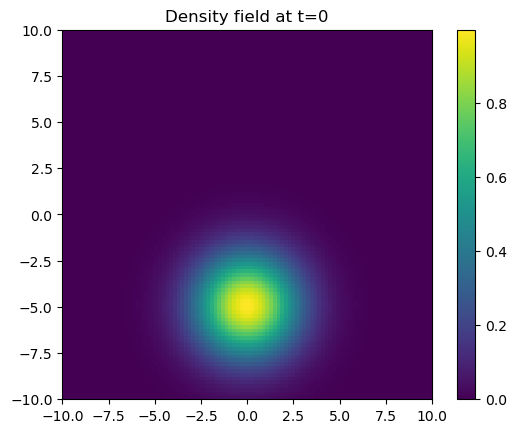

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Define parameters for the evolving Gaussian (density)
def gaussian(x, y, t):
    x0 = 5 * np.sin(t)  # Sinusoidal path in x-direction
    y0 = 5 * np.cos(t)  # Sinusoidal path in y-direction
    sigma = 2  # Spread of the Gaussian
    return np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))

# Generate time snapshots
timesteps = 1000
data = np.zeros((100, 100, timesteps))

for t in range(timesteps):
    data[:, :, t] = gaussian(X, Y, t * 0.1)

# Visualize one time snapshot
plt.imshow(data[:, :, 0], extent=(-10, 10, -10, 10))
plt.title('Density field at t=0')
plt.colorbar()
plt.show()


/home/anindya/anaconda3/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1.7746205112051837e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Eigenvalues (frequencies):
[0.76484117+0.64421784j 0.76484117-0.64421784j 0.82533538+0.56464268j
 0.82533538-0.56464268j 0.87758252+0.47942564j 0.87758252-0.47942564j
 1.        +0.j         0.99500417+0.09983342j 0.99500417-0.09983342j
 0.98006658+0.19866933j 0.98006658-0.19866933j 0.92106101+0.38941839j
 0.92106101-0.38941839j 0.95533648+0.29552021j 0.95533648-0.29552021j]


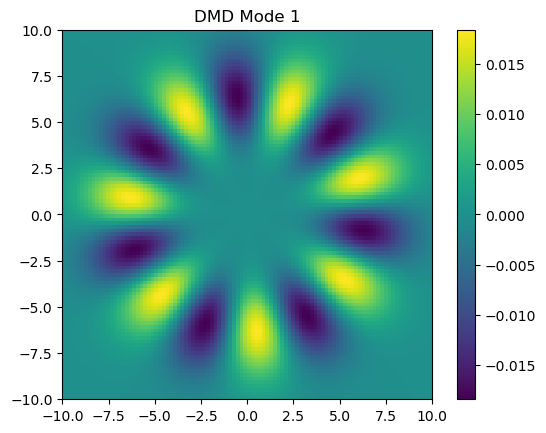

In [19]:
from pydmd import DMD

# Reshape the data for DMD
# DMD expects a 2D matrix, where each column is a flattened snapshot
flattened_data = data.reshape((100 * 100, timesteps))

# Perform DMD
dmd = DMD(svd_rank=15)  # You can adjust svd_rank to extract more/less modes
dmd.fit(flattened_data)

# Extract the eigenvalues (frequencies)
eigenvalues = dmd.eigs
print("Eigenvalues (frequencies):")
print(eigenvalues)

# Extract the DMD modes
modes = dmd.modes

# Reconstruct the data using the DMD modes and eigenvalues
reconstructed_data = dmd.reconstructed_data.real

# Plot one of the DMD modes
plt.imshow(np.real(modes[:, 0].reshape(100, 100)), extent=(-10, 10, -10, 10))
plt.title('DMD Mode 1')
plt.colorbar()
plt.show()


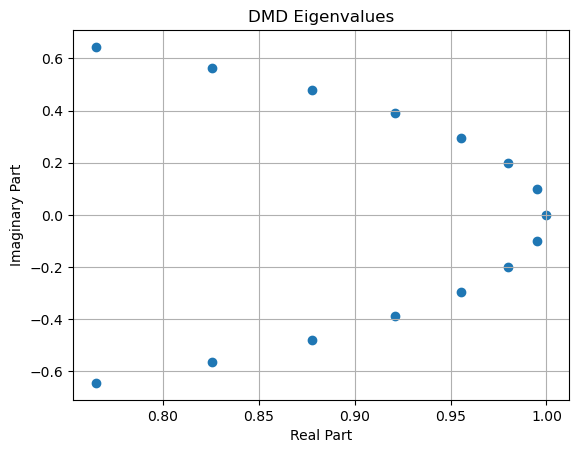

In [20]:
# Plot the eigenvalues (frequencies)
plt.scatter(eigenvalues.real, eigenvalues.imag)
plt.title('DMD Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()


In [8]:
import numpy as np
from pydmd import DMD
from pydmd.preprocessing import hankel_preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm

    
# Function to collect the data from the specified sub-region
def collect_subregion_data(out_dir, Nsteps, grid_x, size_x, start_x):
    """
    This function collects the data for the selected region between 
    start_x and start_x + grid_y for all time steps.
    """
    data_region = np.zeros((grid_y, size_x, Nsteps))  # Sub-region shape: grid_y x grid_y x Nsteps
    
    # for step in tqdm(range(int(start_x//(0.35 * 50)), int((start_x + size_x)//(0.35 * 50))), desc = "Fetching data"):
    for step in tqdm(range(Nsteps), desc = "Fetching data"):
        # Fetch density1 and density2 for the current step
        d1 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,start_x:start_x + size_x], axis=0)
        d2 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,start_x:start_x + size_x], axis=0)
        
        # Subtract densities to get charge density
        charge_density = d1 - d2
        
        # Extract the sub-region from 1/4 * grid_x to 1/4 * grid_x + grid_y
        # data_region[:, :, step] = charge_density[:, start_x:start_x + size_x]
    
    return data_region

# Define start of the sub-region (1/2 way from the left)
start_x = 3000#int(grid_x * 1/2)
size_x = 800
# Collect data for the sub-region
subregion_data = collect_subregion_data(out_dir, Nsteps, grid_x, size_x, start_x)




Fetching data: 100%|███████████████████████████████████████████████████████| 200/200 [05:45<00:00,  1.73s/it]


Downsampled grid_y: 200, downsampled_size_x: 200
Number of snapshots: 200
Size of time_series_data: (40000, 200)
Size of dmd.modes[:, i]: (40000,)


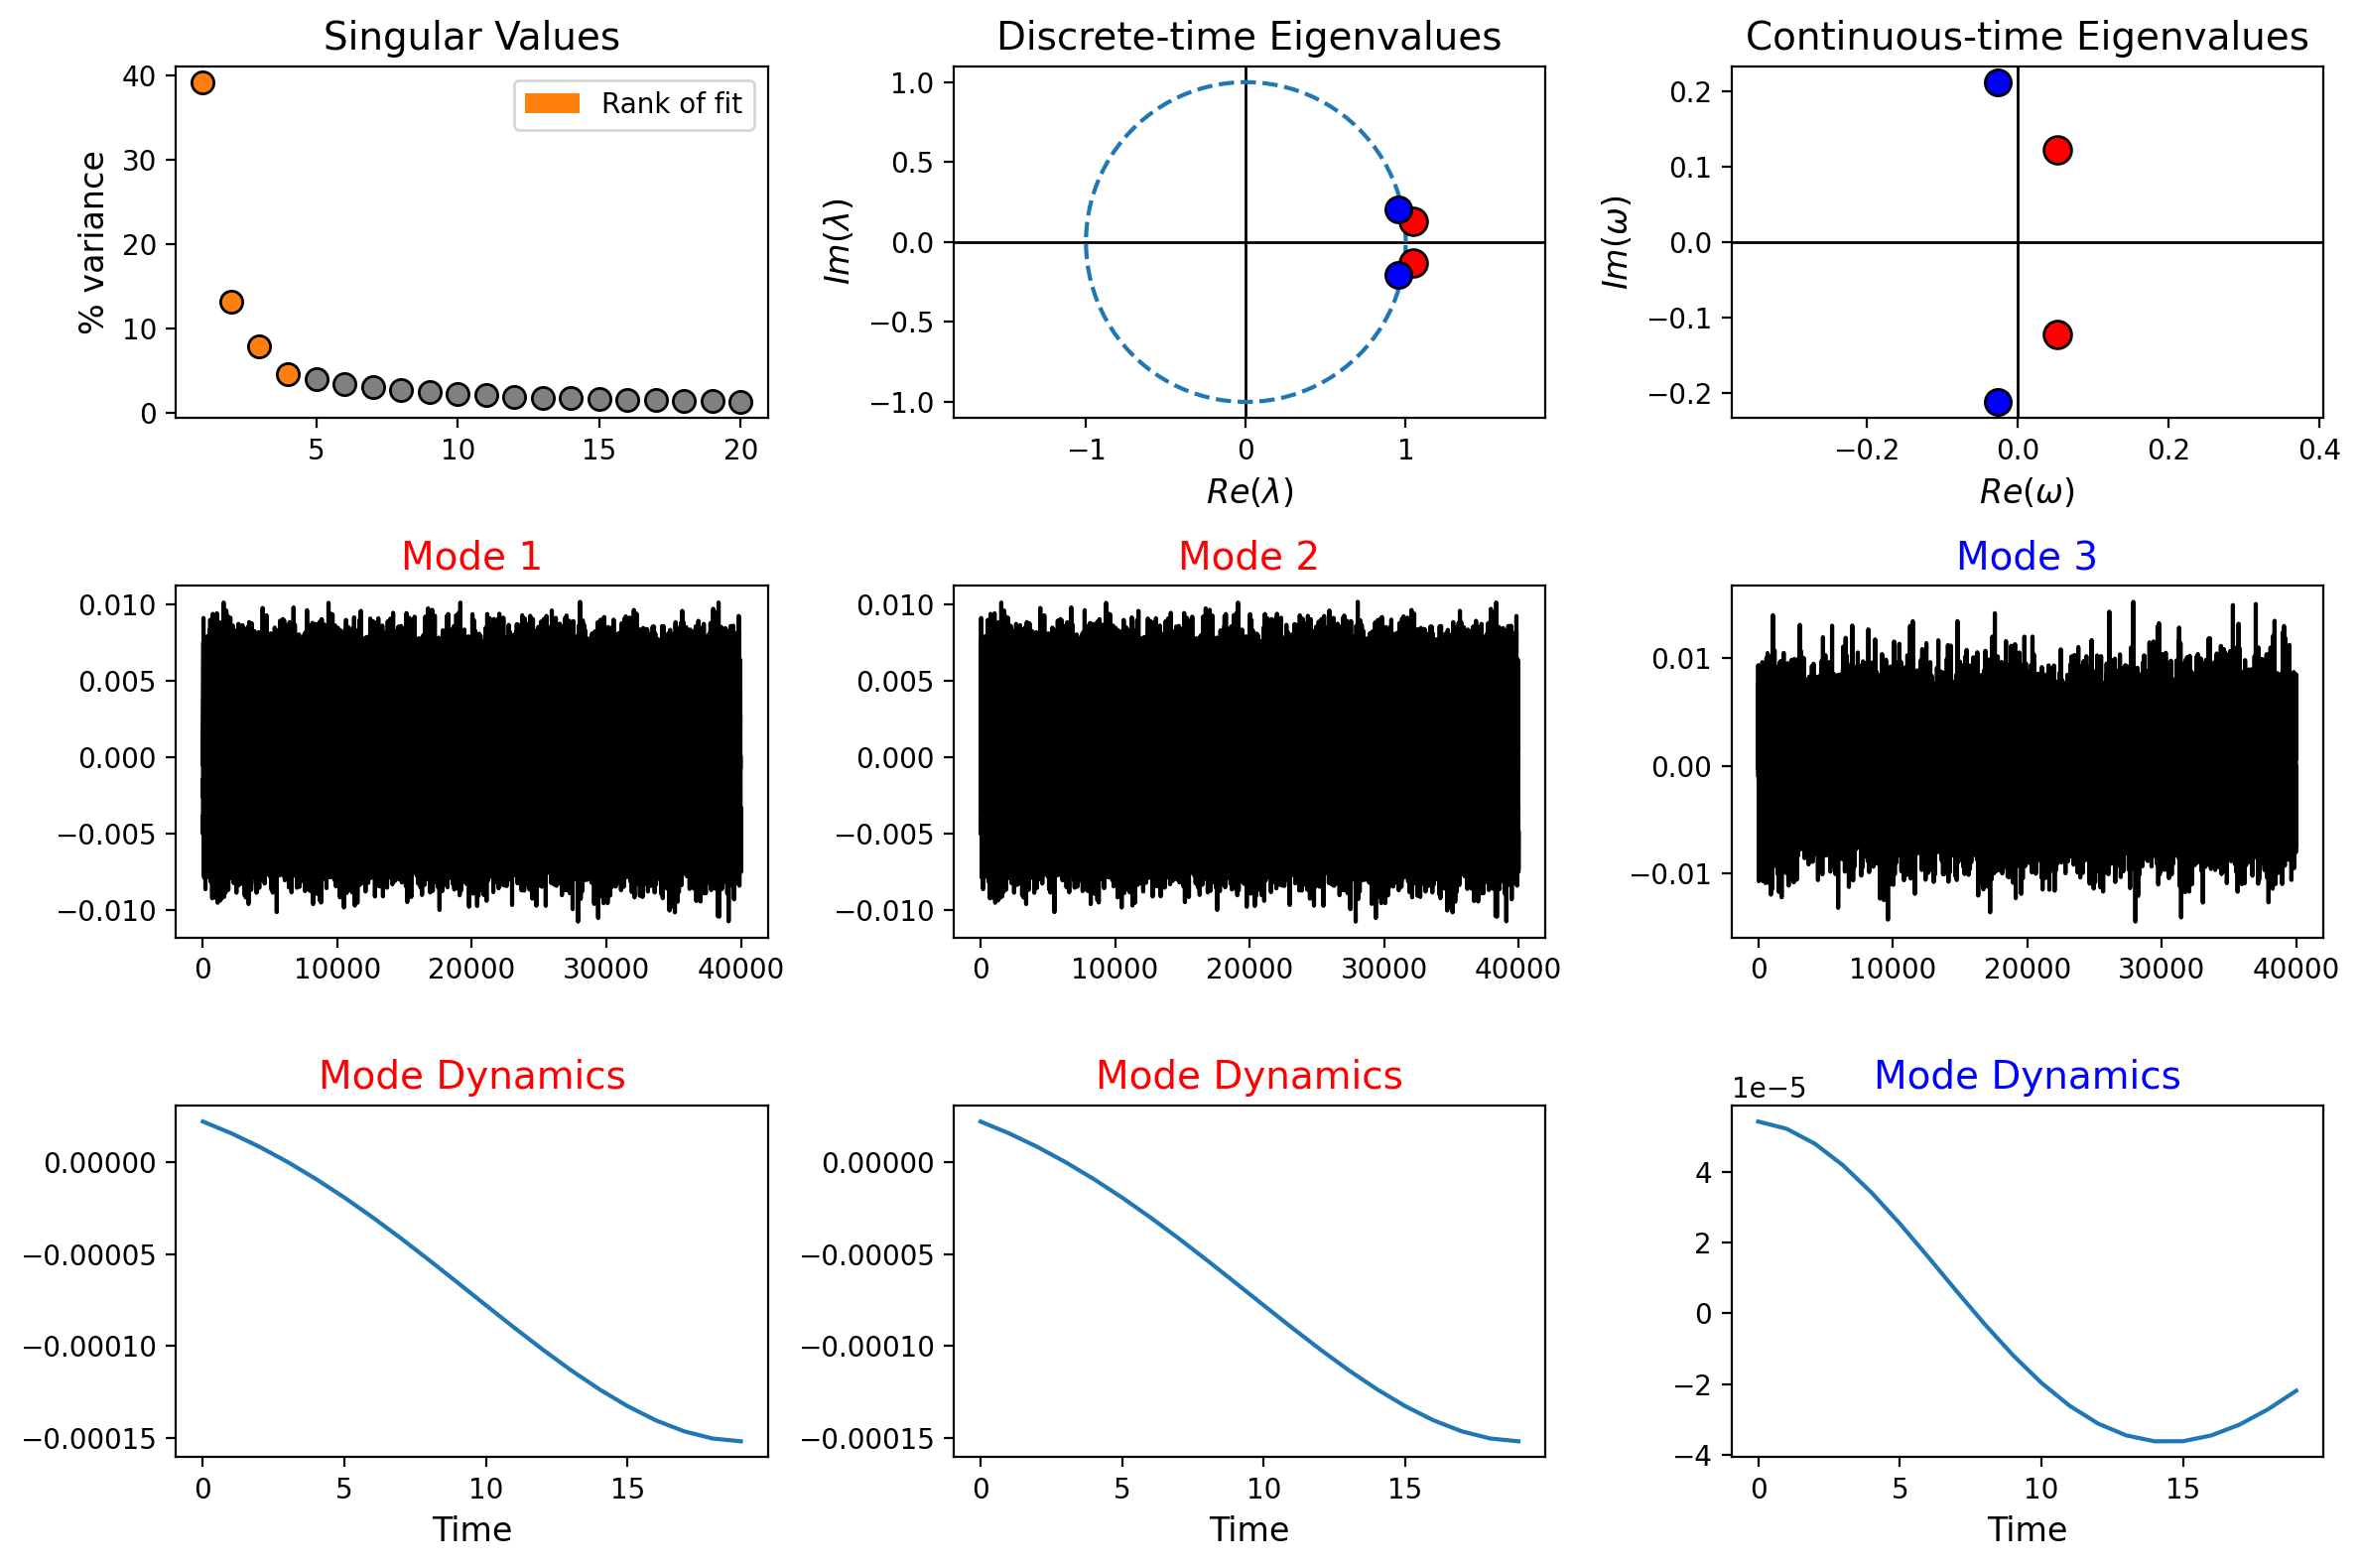

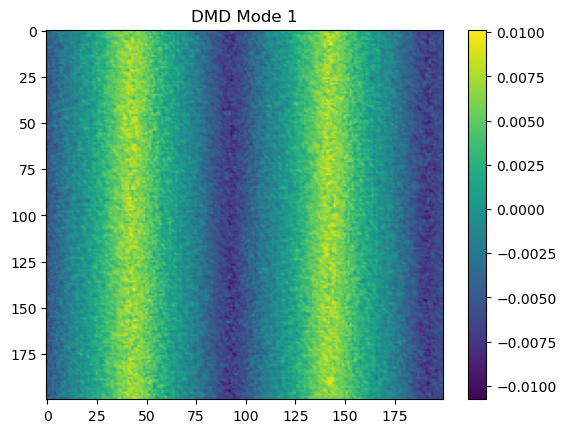

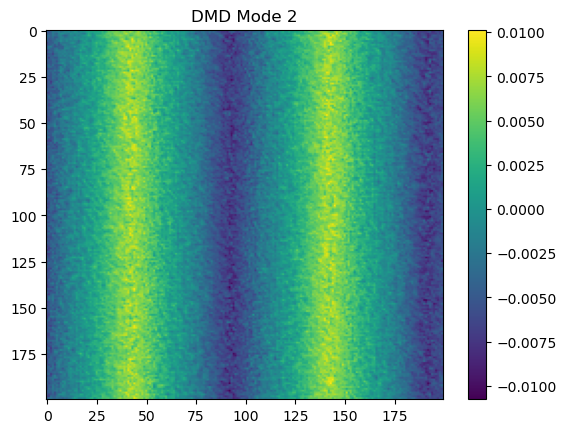

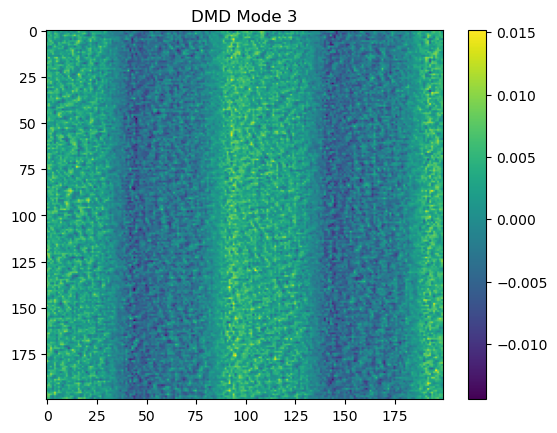

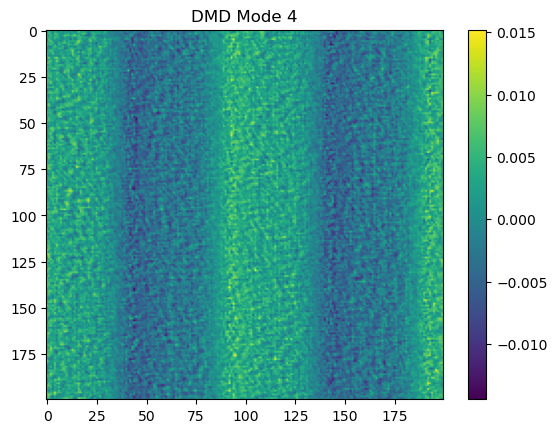

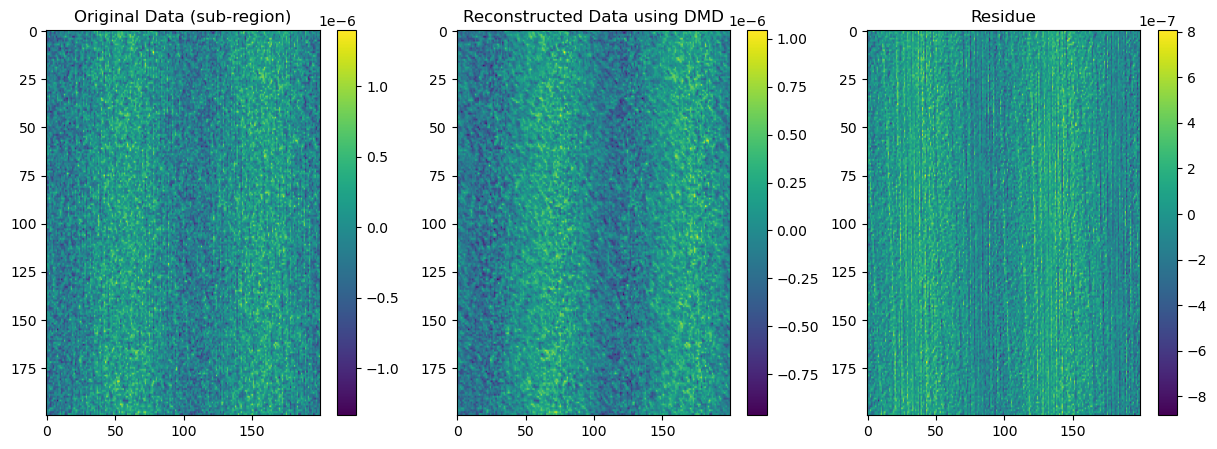

In [47]:
import numpy as np
from pydmd import DMD
from pydmd.plotter import plot_eigs, plot_summary
import matplotlib.pyplot as plt
from tqdm import tqdm

# def downsample_spatial(data, downsample_factor=4):
#     """
#     Downsample the spatial dimensions by slicing.
#     """
#     return data[::downsample_factor, ::downsample_factor]

# # Function to collect the data from the specified sub-region
# def collect_subregion_data(out_dir, grid_x, size_x, start_x, downsample_factor=4):
#     """
#     Collects the charge density data for the selected subregion between 
#     start_x and start_x + size_x for all time steps. 
#     Downsamples spatially by the given factor.
    
#     Returns:
#     - downsampled_subregion_data: downsampled 3D array (downsampled_grid_y, downsampled_size_x, num_snapshots).
#     """
#     # Calculate number of snapshots based on time steps in the sub-region
#     # num_snapshots = int(size_x // (0.35 * 50)) 
#     # start_snapshot = int(start_x // (0.35 * 50)) + 90
    
#     # Initialize an empty list to store the downsampled data
#     downsampled_subregion_data = []

#     # Loop through all time steps and collect the subregion data
#     # for step_idx, step in enumerate(tqdm(range(start_snapshot, start_snapshot + num_snapshots), desc="Fetching data")):
#     for step_idx, step in enumerate(tqdm(range(Nsteps), desc="Fetching data")):
#         # Fetch density1 and density2 for the current step
#         d1 = fetch_var_at_step(out_dir, "flds", step)["dens1"][0, :, start_x:start_x + size_x]
#         d2 = fetch_var_at_step(out_dir, "flds", step)["dens2"][0, :, start_x:start_x + size_x]
        
#         # Subtract densities to get charge density
#         charge_density = CC**2/(ppc0 * COMP**2) * (d1 - d2)
        
#         # Downsample the charge density spatially using slicing
#         downsampled_charge_density = downsample_spatial(charge_density, downsample_factor)
        
#         # Store the downsampled charge density in the list
#         downsampled_subregion_data.append(downsampled_charge_density)
    
#     # Convert list to numpy array and transpose to get shape (downsampled_grid_y, downsampled_size_x, num_snapshots)
#     downsampled_subregion_data = np.array(downsampled_subregion_data)
#     downsampled_subregion_data = np.moveaxis(downsampled_subregion_data, 0, -1)  # Now shape is (downsampled_grid_y, downsampled_size_x, num_snapshots)
    
#     return downsampled_subregion_data

# # Define parameters
# start_x = 4000  # Start at 1/2th of the grid along the x-axis
# size_x = 800 # Size of the subregion
# downsample_factor = 4  # Spatial downsampling factor

# # Collect downsampled data for the sub-region
# subregion_data_downsampled = collect_subregion_data(out_dir, grid_x, size_x, start_x, downsample_factor)

# # Get dimensions
# downsampled_grid_y = subregion_data_downsampled.shape[0]
# downsampled_size_x = subregion_data_downsampled.shape[1]
# num_snapshots = subregion_data_downsampled.shape[2]

# # Reshape the downsampled data for DMD (flatten each frame)
# # The data should have shape (num_features, num_snapshots)
# time_series_data = subregion_data_downsampled.reshape(downsampled_grid_y * downsampled_size_x, num_snapshots)
# Apply DMD
dmd = DMD(svd_rank=4)  # Adjust rank as needed
dmd.fit(time_series_data[:,:20])

# Check the sizes for debugging
print(f"Downsampled grid_y: {downsampled_grid_y}, downsampled_size_x: {downsampled_size_x}")
print(f"Number of snapshots: {num_snapshots}")
print(f"Size of time_series_data: {time_series_data.shape}")
print(f"Size of dmd.modes[:, i]: {dmd.modes[:, 0].shape}")

# # Visualize DMD eigenvalues (frequencies)
# plt.scatter(dmd.eigs.real, dmd.eigs.imag)
# plt.title('DMD Eigenvalues (Frequencies)')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.grid(True)
# plt.show()

plot_summary(dmd, max_sval_plot = 199)
# plot_eigs(dmd, show_axes=True, show_unit_circle=True, figsize=(4, 4))


# Plot the first few DMD modes for inspection
for i in range(min(4, dmd.modes.shape[1])):  # Ensure we don't exceed available modes
    mode = dmd.modes[:, i].real.reshape(downsampled_grid_y, downsampled_size_x)
    plt.imshow(mode[:200, :200], aspect='auto')
    plt.title(f'DMD Mode {i+1}')
    plt.colorbar()
    plt.show()

# Reconstruct the data using the DMD modes and visualize the first time step
reconstructed_data = dmd.reconstructed_data.real

# Visualize original vs reconstructed data for one frame
frame = 5  # Example frame to visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(time_series_data[:, frame].reshape(downsampled_grid_y, downsampled_size_x), aspect='auto')
plt.colorbar()
plt.title('Original Data (sub-region)')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_data[:, frame].reshape(downsampled_grid_y, downsampled_size_x), aspect='auto')
plt.colorbar()
plt.title('Reconstructed Data using DMD')

plt.subplot(1, 3, 3)
plt.imshow(- reconstructed_data[:, frame].reshape(downsampled_grid_y, downsampled_size_x) +
             time_series_data[:, frame].reshape(downsampled_grid_y, downsampled_size_x), aspect='auto')
plt.colorbar()
plt.title('Residue')
plt.show()



In [33]:
import numpy as np
import scipy as sp
# from pydmd import DMD
# from pydmd.plotter import plot_summary
# from pydmd.preprocessing import hankel_preprocessing
import matplotlib.pyplot as plt
import tristanVis.isolde as isolde
from tqdm import tqdm
out_dir = "../slurm_scripts/output/"
run_no = 13
"""
Typical stuff read from the input file
"""
# input_file_name = "../inputs/inputAG.2d_EM_wave_embed"
input_file_name = "../inputs/inputAG.2dtwostream_thermal_Bfield"
hist            = isolde.parseHistory(out_dir + "history")
input_params    = isolde.parseInput(input_file_name)
interval        = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
grid_x          = int(input_params["grid"]["mx0"])
grid_y          = int(input_params["grid"]["my0"])
Nsteps          = int(lst_time// interval)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
ppc0            = input_params["plasma"]["ppc0"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
omegap0         = CC / COMP
time            = hist["time"] * omegap0
B_0             = input_params["problem"]["B_field"]#["B_0"]
# B_amp           = input_params["problem"]["B_amplitude"]
# spread          = input_params["problem"]["spread"]
# mode            = input_params["problem"]["mode"]
# psi             = input_params["problem"]["psi"]


"""
A WORD FROM ANINDYA (2/6/2024) ABOUT UNITS !!
#############################################

In my experience with Tristan code units, its most convenient to use dimensionless units of time and space.
Set code time steps and space steps to 1 (like, mentally : you don't have to do anything).
dt = 1
dx = 1

Then omegap0 is the plasma frequency in this units = CC / COMP dt^-1 = CC/COMP
And Debye length / skin-depth, d_e = COMP dx = COMP.

If (x,t) is (space,time) in code units then use the dimensionless (x/d_e, omegap0 * t) for all physics expressions/ theory.

BTW, in these units defined as such speed of light is c = CC dx/dt = CC.
"""

def fetch_var_at_step(out_dir, var, step):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        return(isolde.getParticles(filename))
    elif var == "flds":
        return(isolde.getFields(filename))
    else:
        print("Not supported yet!")
        return False

"""
TEMPLATES to fetch density, electric field and particle positions / velocities
##############################################################################

# density = np.zeros(shape = (2, Nsteps,grid_x))
# for step in range(Nsteps):
#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]

# Ex = np.zeros(shape = (Nsteps,grid_x))
# for step in range(Nsteps):
#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]

"""
# density1 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# density2 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ex = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ey = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bz = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jy = np.zeros(shape = (Nsteps, grid_y, grid_x))

# X1 = []
# ux_1 = []
# Y1 = []
# uy_1 = []
# X2 = []
# ux_2 = []
# Y2 = []
# uy_2 = []


# for step in tqdm(range(Nsteps)):
#     # density1[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)
#     # density2[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,:], axis = 0)
    # X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
    # ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
    # Y1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['y'])
    # uy_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['v'])

    # X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
    # ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
    # Y2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['y'])
    # uy_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['v'])
    
    # Jx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jx"][:,:,:], axis = 0)
    # Ex[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ex"][:,:,:], axis = 0)
    # Jy[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jy"][:,:,:], axis = 0)
    # Ey[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ey"][:,:,:], axis = 0)
    #Ey[step,:,:]       = fetch_var_at_step(out_dir, "flds", step)["ey"][0,:,:]
    #Bx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bx"][:,:,:], axis = 0)
    # Bz[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bz"][:,:,:], axis = 0)
# X1=np.array(X1)
# ux_1 = np.array(ux_1)
# Y1=np.array(Y1)
# uy_2 = np.array(uy_2)

'\nTEMPLATES to fetch density, electric field and particle positions / velocities\n##############################################################################\n\n# density = np.zeros(shape = (2, Nsteps,grid_x))\n# for step in range(Nsteps):\n#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]\n#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]\n\n# Ex = np.zeros(shape = (Nsteps,grid_x))\n# for step in range(Nsteps):\n#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]\n\n'

In [60]:
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def collect_subregion_data(out_dir, steps, grid_y, size_x, start_x):
    """
    Collects the charge density data for a selected subregion over all time steps.
    """
    data_region = np.zeros((grid_y, size_x, steps))  # Sub-region shape: grid_y x size_x x Nsteps

    for step in tqdm(range(steps), desc="Fetching data"):
        # Fetch densities for the current step
        dens1 = fetch_var_at_step(out_dir, "flds", step)["dens1"][:, :grid_y, start_x:start_x + size_x]
        dens2 = fetch_var_at_step(out_dir, "flds", step)["dens2"][:, :grid_y, start_x:start_x + size_x]
        
        # Compute charge density
        charge_density = dens1 + dens2  # Assuming dens1 and dens2 are 2D arrays
        
        # Store the charge density in data_region
        data_region[:, :, step] = charge_density

    return data_region

def compute_fft_over_time(data_region):
    """
    Computes the 2D FFT of the charge density data for each time step.
    """
    grid_y, size_x, steps = data_region.shape
    fft_data_all = np.zeros((grid_y, size_x, steps), dtype=complex)

    for step in tqdm(range(steps), desc="Computing FFT"):
        charge_density = data_region[:, :, step]
        
        # Compute the 2D FFT
        fft_data = np.fft.fft2(charge_density)
        
        # Shift the zero frequency component to the center
        fft_shifted = np.fft.fftshift(fft_data)
        
        # Store the FFT data
        fft_data_all[:, :, step] = fft_shifted

    return fft_data_all

def extract_mode_amplitudes(fft_data_all):
    """
    Extracts the amplitude (magnitude) of each mode over time.
    """
    amplitude_data = np.abs(fft_data_all)
    return amplitude_data

def exponential_growth(t, A, gamma):
    return A * np.exp(gamma * t)

def compute_growth_rates(amplitude_data, time_array):
    """
    Computes the growth rates for each mode by fitting amplitude vs. time.
    """
    grid_y, size_x, steps = amplitude_data.shape
    growth_rates = np.zeros((grid_y, size_x))
    log_amplitude = np.log(amplitude_data + 1e-30)  # Avoid log(0)
    
    for i in tqdm(range(grid_y), desc="Computing growth rates"):
        for j in range(size_x):
            y_data = log_amplitude[i, j, :]
            t_data = time_array

            # Fit to linear function since ln(A*exp(gamma*t)) = ln(A) + gamma*t
            def linear_fit(t, lnA, gamma):
                return lnA + gamma * t

            try:
                popt, _ = curve_fit(linear_fit, t_data, y_data)
                growth_rates[i, j] = popt[1]  # Extract gamma
            except RuntimeError:
                growth_rates[i, j] = np.nan  # Fit did not converge

    return growth_rates

def compute_wavenumbers(grid_size, dx):
    """
    Computes the wavenumber arrays for FFT data.
    """
    k = np.fft.fftshift(np.fft.fftfreq(grid_size, d=dx)) * 2 * np.pi
    return k


In [62]:
size_x = 1000  # Size of the subregion in x-direction
start_x = 0  # Starting x index
dx = 1  # Spatial resolution in x-direction
dy = 1  # Spatial resolution in y-direction
total_time = 120  # Total simulation time
steps = 120
time_array = np.linspace(0, total_time, steps)

# Step 1: Collect Data
data_region = collect_subregion_data(out_dir, steps, 400, size_x, start_x)

# Step 2: Compute 2D FFT
fft_data_all = compute_fft_over_time(data_region)

# Step 3: Extract Mode Amplitudes
amplitude_data = extract_mode_amplitudes(fft_data_all)

# Step 4: Compute Growth Rates
growth_rates = compute_growth_rates(amplitude_data, time_array)/interval






Computing growth rates: 100%|██████████████████████████████████████████████| 400/400 [02:20<00:00,  2.85it/s]


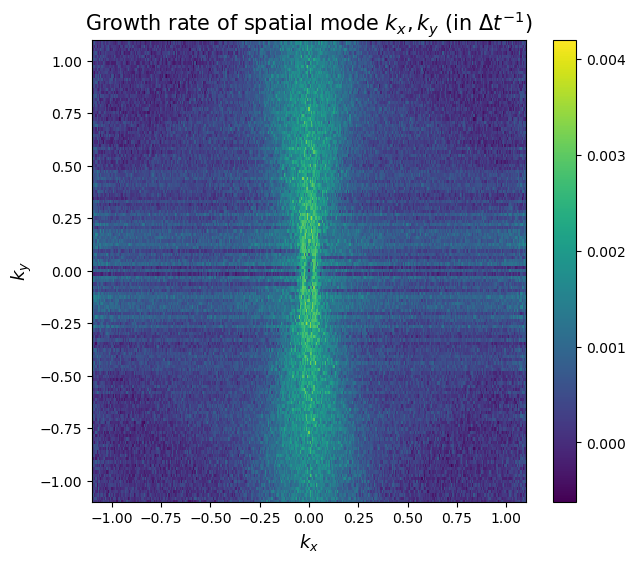

Fastest Growing Mode: kx = -0.0439822971502571, ky = 1.2566370614359172, growth rate = 0.00420142867587468
lengthscale = 142.85714285714286


In [63]:
# Step 5: Plot Growth Rates

# Compute Wavenumbers
kx = compute_wavenumbers(size_x, dx)
ky = compute_wavenumbers(400, dy)

def plot_growth_rates(growth_rates, kx, ky):
    """
    Plots the growth rates of the modes.
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.pcolormesh(kx, ky, growth_rates, shading='auto')
    fig.colorbar(im)
    ax.set_xlabel(r'$k_x$', fontsize = 13)
    ax.set_ylabel(r'$k_y$', fontsize = 13)
    ax.set_title(r'Growth rate of spatial mode $k_x, k_y$ (in $\Delta t ^{-1}$)', fontsize = 15)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    
    plt.show()
    
plot_growth_rates(growth_rates, kx, ky)

import numpy as np

def find_max_growthrate_in_region(growth_rates, kx, ky, kx_min, kx_max, ky_min, ky_max):
    """
    Finds the maximum growth rate within a specified region of kx and ky.
    
    Parameters:
    - growth_rates: 2D array of growth rates for each mode (k_x, k_y).
    - kx: 1D array of wavenumbers in the x-direction.
    - ky: 1D array of wavenumbers in the y-direction.
    - kx_min, kx_max: Minimum and maximum values of kx for the region.
    - ky_min, ky_max: Minimum and maximum values of ky for the region.
    
    Returns:
    - fastest_mode: tuple of (kx, ky, max_growth_rate) for the fastest-growing mode in the region.
    """
    # Create masks for kx and ky within the desired range
    kx_mask = (kx >= kx_min) & (kx <= kx_max)
    ky_mask = (ky >= ky_min) & (ky <= ky_max)
    
    # Find the indices where kx and ky fall within the desired ranges
    kx_indices = np.where(kx_mask)[0]
    ky_indices = np.where(ky_mask)[0]
    
    # Extract the sub-region of the growth rates
    growth_rates_region = growth_rates[np.ix_(ky_indices, kx_indices)]
    
    # Find the index of the maximum growth rate in the sub-region
    local_max_idx = np.unravel_index(np.argmax(growth_rates_region, axis=None), growth_rates_region.shape)
    
    # Map back to the global indices
    global_max_idx = (ky_indices[local_max_idx[0]], kx_indices[local_max_idx[1]])
    
    # Extract the corresponding kx, ky, and maximum growth rate
    kx_fastest = kx[global_max_idx[1]]
    ky_fastest = ky[global_max_idx[0]]
    max_growth_rate = growth_rates[global_max_idx]
    
    return kx_fastest, ky_fastest, max_growth_rate


# Example usage:
kx_fastest, ky_fastest, max_growth_rate = find_max_growthrate_in_region(growth_rates, kx, ky, -2.5, 2.5, -2.5, 2.5)
print(f"Fastest Growing Mode: kx = {kx_fastest}, ky = {ky_fastest}, growth rate = {max_growth_rate}")

print("lengthscale = {}".format(np.abs(2*np.pi/kx_fastest)))